# Pratical session 2 of Quantum Information and Dynamics

## General comments

The practical session uses this notebook. It should be returned by Friday December 22 at the address 
[Brigitte.Bidegaray@univ-grenoble-alpes.fr](mailto:Brigitte.Bidegaray@univ-grenoble-alpes.fr).
The name of the file should at least contain your familly name. 
If your file is more that one 1Mo, please consider deleting the execution results (we will in any case rerun the notebook).

The general framework (physical constants, input wave...) are given and then you should complete the cells with code to answer the questions <b>and</b> add Markdown cells to comment the numerical results.  


# Numerical resolution of the Maxwell-Bloch coupling

This practical concerns the numerical resolution of the Maxwell-Bloch coupling
\begin{equation*}
\left\{ \begin{aligned} 
\partial_t B & = - \partial_z E,\\
\partial_t E & = - v^2 \partial_z B - \frac{1}{\varepsilon} J, \quad \hbox{with} \quad J = N_a g(z) \operatorname{tr} \big( \frac{\mathrm{d}}{\mathrm{d} t} \rho(t) p \big),\\
i \hbar \frac{\mathrm{d}}{\mathrm{d} t} \rho(t) &= [H_0 + pE(t), \rho(t)],
 \end{aligned} \right.
\end{equation*}
completed with initial and boundary conditions. For simplicity, we do not consider here relaxations.

In [1]:
import numpy as np
from math import sqrt, pi
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [2]:
# Physical constants
hbar        = 1.05457*1e-34  # [J s]  reduced Planck's constant
charge_elem = 1.60218*1e-19  # [C]    Electron's charge
kb          = 1.38066*1e-23  # [J/K]  Boltzmann's constant

eps_0       = 8.85419*1e-12  # [F/m]  Vacuum's permeability
speed_light = 2.997925*1e8   # [m/s]  Speed-light
mu_0        = 1.0 / (speed_light**2 * eps_0)   # [H/m]  Vacuum's permeattivity

In [3]:
# Dimension of the matrix density
N_band = 3

# H_0 parameters (Eg is the gap energy)
Eg = 0.36 * charge_elem              
energies = np.array([0, 2, 3]) * Eg
H0 = np.diag(energies)

# Polarizability matrix
pmax = 1e-29
p_mat = (np.ones((N_band, N_band)) - np.eye(N_band)) * pmax

# permittivity and permeability
eps_r = 1.0
eps = eps_r * eps_0
mu_r = 1.0
mu = mu_r * mu_0
v = 1.0 / sqrt(eps * mu)

# frequency and wavelength
omega = Eg / hbar
wavelength = 2.0 * pi * v / omega

# I. Maxwell's equations

We first consider the one dimensional Maxwell's equations defined on $]0,T_{max}]\times]0,L[$ by
\begin{equation*}
\left\{ \begin{aligned} 
\partial_t B & = - \partial_z E,\\
\partial_t E & = - v^2 \partial_z B, 
\end{aligned} \right.
\end{equation*}
completed with the initial conditions $B(0,z)=0$ and $E(0,z)=0$ and the boundary conditions $E(t,0)=E_{inc}(t)$ and $E(t,L)=0$.

We introduce a uniform space discretization using $N_z$ points ($z_j=j\delta z$, for $j=0,\cdots,N_z-1$ where $\delta z=\frac{L}{N_z-1}$) and a uniform time discretization using $N_t$ points ($t_p=p\delta t$, for $p=0,\cdots,N_t-1$ where $\delta t=\frac{T_{max}}{N_t-1}$). $\delta z$ is chosen with respect to the wavelength of the injected electromagnetic wave and $\delta t$ with respect to the CFL condition of the numerical scheme. 

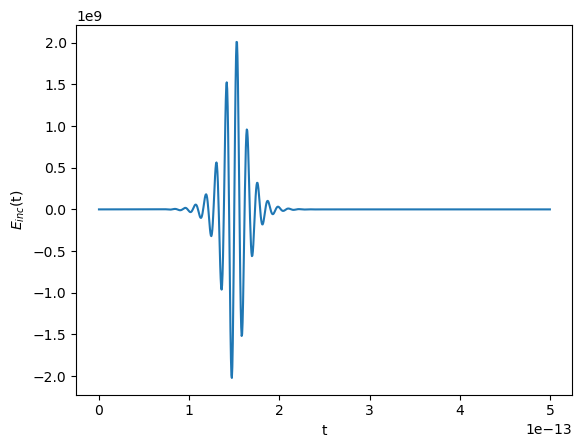

In [4]:
# Space discretization
Nz_per_wavelength = 20
deltaz = wavelength / Nz_per_wavelength
Nz = 35 * (Nz_per_wavelength) + 1
L = (Nz - 1) * deltaz
z = np.linspace(0, L, Nz)

# Time discretization
Tmax = 5e-13
lambd = 0.9
deltat = lambd * deltaz / v
Nt = int(Tmax / deltat) + 1
t = np.linspace(0, Tmax, Nt)

# Injected field
def incident_field(t):
    tau_p = 1e-14
    t0 = 15 * tau_p
    k = 2
    E0 = k * hbar / (pmax * tau_p)
    
    return E0 * np.sin(omega * (t-t0)) / np.cosh((t-t0) / tau_p)
    
fig = plt.figure()
plt.plot(t,incident_field(t))
plt.xlabel('t')
plt.ylabel(r'$E_{inc}$(t)');

## Yee's scheme

We remind that the Yee's scheme is defined by
\begin{equation*}
\frac{B^{p+1/2}_{j+1/2} - B^{p-1/2}_{j+1/2}}{\delta t} + \frac{E^p_{j+1} - E^{p}_{j}}{\delta z} = 0, 
\quad \forall j=0, \dots, N_z-2,
\end{equation*}
\begin{equation*}
\frac{E^{p+1}_j - E^p_j}{\delta t} + v^2 \frac{B^{p+1/2}_{j+1/2} - B^{p+1/2}_{j-1/2}}{\delta z} = 0, 
\quad \forall j=1, \dots, N_z-2,
\end{equation*}
completed with the initial and boudary conditions. Its implementation is given by the following function.

In [5]:
def maxwell(dz, dt, Nz, Nt):
    E = np.zeros((Nt, Nz))
    B = np.zeros((Nt, Nz-1))

    for p in range(1, Nt):
        E[p, 0] = incident_field(t[p])
        for j in range(0, Nz-1):
            B[p, j] = B[p-1, j] - dt / dz * (E[p-1, j+1] - E[p-1, j])
            if j != 0:
                E[p, j] = E[p-1, j] - dt / dz * v**2 * (B[p, j] - B[p, j-1])
        E[p, -1] = 0.0
        
    return E, B

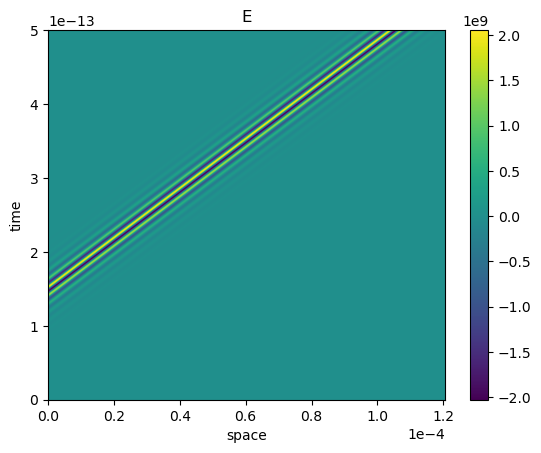

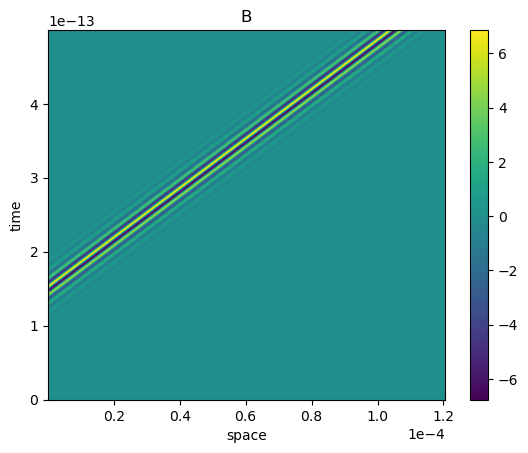

In [6]:
# Maxwell resolution
[E, B] = maxwell(deltaz, deltat, Nz, Nt)

# plot
fig = plt.figure()
plt.imshow(E, origin='lower', aspect='auto', extent=[z[0], z[-1], t[0], t[-1]])
plt.xlabel(r'space')
plt.ylabel(r'time')
plt.title(r'E')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.colorbar(orientation='vertical');

fig = plt.figure()
plt.imshow(B, origin='lower', aspect='auto', extent=[z[0]+deltaz/2.0, z[-1]-deltaz/2.0, t[0]-deltat/2.0, t[-1]-deltat/2.0])
plt.xlabel(r'space')
plt.ylabel(r'time')
plt.title(r'B')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.colorbar(orientation='vertical');

### Question I.1. 
Study numerically the stability of the scheme.

In [7]:
# TO DO

### Question I.2. 
Choosing a discontinuous injected field, illustrate that this scheme is dispersive. You can plot the solution with respect to $t$ for different given values of $z$.

In [9]:
# TO DO

# II. Maxwell-Bloch coupling 

We assume that a unique quantum dot, with a prescribed volumic density $N_a$, is inserted in the middle of the space domain (represented by the index $j_D$, i.e. $g(x_j)=\delta_{jj_D}$).

In [12]:
# Bloch parameters 
rho_init = np.zeros(N_band)
rho_init[-1] = 1
jD = int((Nz-1) / 2) + 1
N_a = 1.0e27

### Question II.1. 
Merge the code of the previous section with the one of the practical session 1 to tackle the Maxwell-Bloch coupling without feedback of the quantum dot on the electromagnetic field
\begin{equation*}
\left\{ \begin{aligned} 
\partial_t B & = - \partial_z E,\\
\partial_t E & = - v^2 \partial_z B,\\
i \hbar \frac{\mathrm{d}}{\mathrm{d} t} \rho(t) &= [H_0 + pE(t), \rho(t)].
 \end{aligned} \right.
\end{equation*}
We make the following choices for the coupling discretization
\begin{equation*}
\rho^{p+1/2}_{j_D} = S_{\operatorname{Rn}}(\frac{\delta t}{2}) S_E(\delta t, E^p_{j_D}) S_{\operatorname{Rn}}(\frac{\delta t}{2}) \rho^{p-1/2}_{j_D},
\end{equation*}
\begin{equation*}
\frac{B^{p+1/2}_{j+1/2} - B^{p-1/2}_{j+1/2}}{\delta t} + \frac{E^p_{j+1} - E^{p}_{j}}{\delta z} = 0,
\end{equation*}
\begin{equation*}
\frac{E^{p+1}_j - E^p_j}{\delta t} + v^2 \frac{B^{p+1/2}_{j+1/2} - B^{p+1/2}_{j-1/2}}{\delta z} = 0.
\end{equation*}
Observe the self-induced transparency phenomena.

In [13]:
# TO DO

### Question II.2. (to go further)
Add the feedback of the quantum dot on the electromagnetic field via the polarization current:
\begin{equation*}
\rho^{p+1/2}_{j_D} = S_{\operatorname{Rn}}(\frac{\delta t}{2}) S_E(\delta t, E^p_{j_D}) S_{\operatorname{Rn}}(\frac{\delta t}{2}) \rho^{p-1/2}_{j_D},
\end{equation*}
\begin{equation*}
\frac{B^{p+1/2}_{j+1/2} - B^{p-1/2}_{j+1/2}}{\delta t} + \frac{E^p_{j+1} - E^{p}_{j}}{\delta z} = 0,
\end{equation*}
\begin{equation*}
\frac{E^{p+1}_j - E^p_j}{\delta t} + v^2 \frac{B^{p+1/2}_{j+1/2} - B^{p+1/2}_{j-1/2}}{\delta z} =  - \frac{1}{\varepsilon} J_j^{p+1/2}, \quad \hbox{with} \quad J_j^{p+1/2}=N_a g(x_j) \operatorname{tr} \big(p \operatorname{Rn}(\rho^{p+1/2}_j)\big).
\end{equation*}
Play with the value of $N_a$ and comment the results.

In [16]:
# TO DO